## **_SARSA Agent_ para el ambiente _Lunar Lander_**

### **Importando dependencias**

In [1]:
!pip install box2d-py
!pip install gym[Box_2D]
import gym

     |████████████████████████████████| 450kB 14.0MB/s 


In [2]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

### **Acceder a los directorios de _drive_**

In [3]:
from google.colab import drive

In [4]:
drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/My Drive/DATASETS"

Mounted at /content/gdrive
/content
/content/gdrive/My Drive/DATASETS


### **Modelo de red neuronal**

In [5]:
class DNN:
  def __init__(self, stateSize, actionSize, hidden=24, lr=0.003):
    self._stateSize = stateSize
    self._actionSize = actionSize
    self._hidden = hidden
    
    # declarando el modelo
    self._model = torch.nn.Sequential(
        torch.nn.Linear(self._stateSize, self._hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(self._hidden, self._actionSize),
    )

    # instanciando el modelo en la GPU
    self._device = torch.device(0) if torch.cuda.is_available() else None
    self._model.to(self._device)

    # declarando la función de pérdida y el optimizador
    self._lr = lr
    self._loss = torch.nn.MSELoss()
    self._optm = torch.optim.Adam(self._model.parameters(), lr=self._lr)


  def predict(self, state):
    # cargamos el estado como un tensor en la GPU
    x = torch.tensor(state, dtype=torch.float32, requires_grad=True, device=self._device)
    # (1) paso forward
    y = self._model(x)
    # retornar un ndarray desvinculado de la GPU
    return y.to('cpu').detach().numpy()


  def fit(self, state, target, epochs):
    # cargamos el estado como un tensor en la GPU
    x = torch.tensor(state, dtype=torch.float32, requires_grad=True, device=self._device)
    # cargamos el target como un tensor en la GPU
    t = torch.tensor(target, dtype=torch.float32, requires_grad=True, device=self._device)

    for e in range(epochs):
      # (1) paso forward
      y = self._model(x)
      # (2) calculo de la función de pérdida
      loss = self._loss(y, t)
      # (3) paso backpropagation
      # ponemos a cero los gradientes
      self._optm.zero_grad()
      # calculamos todas las derivadas automaticamente
      loss.backward()
      # actualizamos los pesos mediante gradiente descendente
      self._optm.step()


  def load(self, path):
      self._model.load_state_dict(torch.load(path))


  def save(self, path):
      torch.save(self._model.state_dict(), path)


  def __str__(self):
    return 'model: {}\ndevice: {}'.format(self._model, self._device)


### **Agente**

In [6]:
class SARSAAgent:
  def __init__(self, environment, path):
    """ Inicializar el agente

    Args:
        environment (gym.wrappers.time_limit.TimeLimit): ambiente en el que se desenvuelve el agente
    """
    # resguardamos el ambiente
    self._env = environment
    self._stateSize  = self._env.observation_space.shape[0]
    self._actionSize = self._env.action_space.n

    # reservamos memoria para almacenar los estados requeridos para el
    # aprendizaje
    self._memory = deque(maxlen=10000)
    # generamos el modelo de NN
    self._model = DNN(stateSize=self._stateSize, actionSize=self._actionSize)
    self._path = path
    
    # parámetros que decaerán con el tiempo
    self._gamma = 0.95
    self._epsilon = 1.0
    # constantes para decaer los parámetros
    self._minEpsilon = 0.01
    self._decay = 0.995


  def _mapState(self, state):
    """ Transformar el estado continuo en un estado discreto mediante el empleo de buckets

    Args:
        state (tuple): el estado actual del ambiente

    Returns:
        list: el estado transformado
    """
    return np.reshape(state, [1, self._stateSize])


  def _capacity(self):
    """ Entregar la capacidad actual de nuestro buffer de memoria

    Returns:
        int: capacidad actual de nuestro buffer de memoria
    """
    return len(self._memory)


  def _chooseAction(self, state):
    """ Obtener la la mejor accion posible dado el estado del ambiente

    Args:
        state (numpy.ndarray): el estado actual del ambiente

    Returns:
        int: la mejor accion posible
    """
    # aleatoriamente regresamos una acción aleatoria para ayudar al
    # agente a que no caiga en un minimo local
    if np.random.rand() <= self._epsilon:
        return random.randrange(self._actionSize)
    # retornamos la mejor accion posible
    QValues = self._model.predict(state)
    return np.argmax(QValues[0])


  def _memorize(self, state, newState, action, newAction, reward, done):
    """ Alamacenar en la memoria del agente el estado general del ambiente en
        un instante del entrenamiento 

    Args:
        state (tuple):  estado actual del ambiente
        newState ([type]): estado nuevo a partir de la acción generada
        action ([type]): acción realizada por el agente
        newAction ([type]): acción realizada por el agente a partir del nuevo estado
        reward (float): recompensa otorgada en base a la acción
        done (bool): si el ambiente ha terminado su ejecución o no
    """
    self._memory.append((state, newState, action, newAction, reward, done))


  def _learn(self, batchSize, lr=0.01):
    """ Entrenar el modelo en base a la memoria acumulada del agente

    Args:
        batchSize (int): porción de la memoria que se empleará para 
                          entrenar el modelo
    """
    # se extraen un batch con los estados más recientes
    batch = random.sample(self._memory, batchSize)

    for state, newState, action, newAction, reward, done in batch:
      # empleamos la recompensa del estado general como target para entrenar,
      # esto en caso de que en dicho estado el ambiente siga activo. En caso contrario,
      # se calcula la recompensa correspondiente según la ecuación de Bellman
      target = reward if done else lr*(reward + self._gamma*(self._model.predict(newState)[0][newAction] - self._model.predict(state)[0][action]))
      # calculamos los Q-values con nuestro modelo actual
      target_f = self._model.predict(state)
      # reemplazamos el Q-value correspondiente a la acción generada en el estado general
      # por la recompensa calculada
      target_f[0][action] = target
      # con los Q-values como target, entrenamos nuestro modelos
      self._model.fit(state, target_f, epochs=1)

    # decaer el exploration rate por episodio
    if self._epsilon > self._minEpsilon:
        self._epsilon *= self._decay


  def learn(self, episodes, timesteps, batchSize=32, save=False, load=False):
    """ Someter al agente al proceso de aprendizaje

    Args:
        episodes (int): épocas de entrenamiento
        timesteps (int): instantes de tiempo en los que el ambiente se entrenará/evaluará
        batchSize (int): porción de la memoria que se empleará para entrenar el modelo. Defaults to 32.
    """
    rewards = list()
    epsilon = list()

    # cargar la matriz de pesos en la NN
    if load:
      self._model.load(self._path)

    # para cada epoca de entrenamiento
    for episode in range(episodes):
      tmp = 0
      # obtenemos el estado actual del ambiente y lo redimensionamos
      state = self._env.reset()
      state = self._mapState(state)
      # durante X pasos generaremos una acción sobre el ambiente
      # y obtendremos una recompensa.
      for t in range(timesteps):
        # AGENTE EJECUTA ACCIÓN DADO EL ESTADO ACTUAL
        action = self._chooseAction(state)
        # obtendremos el estado nuevo del ambiente ante el estimulo dado por el agente
        # y lo redimencionamos también
        newState, reward, done, _ = self._env.step(action)
        newState = self._mapState(newState)
        # AGENTE EJECUTA ACCIÓN DADO EL NUEVO ESTADO
        newAction = self._chooseAction(newState)
        # ALMACENAMOS EN MEMORIA DEL AGENTE EL ESTADO GENERAL DEL AMBIENTE   
        self._memorize(state, newState, action, newAction, reward, done)
        # actualizamos el estado actual con el nuevo
        state = newState
        tmp += reward
        # si terminó la época, salimos
        if done:
          rewards.append(tmp)
          epsilon.append(self._epsilon)
          print("episode: {}/{}, steps: {}, R: {} ε: {}" .format(episode, episodes, t, tmp, self._epsilon))
          break
        # SI SE TIENEN LOS DATOS SUFICIENTES, ENTRENAR EL MODELO DEL AGENTE
        if self._capacity() > batchSize:
          self._learn(batchSize)

        # guardar la matriz de pesos cada ciertas épocas
        if save and episode%10 == 0:
          self._model.save(self._path)


    # cerramos el ambiente
    self._env.close()

    return rewards, epsilon



  def run(self, episodes, load=False):
    """ Hacer que el agente interactue con el ambiente

    Args:
        load (bool): flag para indicar al agente si debe o no cargar los pesos. Defaults to False.

    Returns:
        int: intantes de tiempo que duró el agente interactuando con el ambiente
    """
    # cargar la matriz de pesos en la NN
    if load:
      self._model.load(self._path)

    rewards = list()

    # para cada epoca de entrenamiento
    for episode in range(episodes):
      tmp, t = 0, 0
      done = False
      # obtenemos el estado actual del ambiente y lo redimensionamos
      state = self._env.reset()
      state = self._mapState(state)

      while not done:
        # self._env.render()
        t = t + 1
        # AGENTE EJECUTA ACCIÓN DADO EL ESTADO ACTUAL
        action = self._chooseAction(state)
        # obtendremos el estado nuevo del ambiente ante el estimulo dado por el agente
        # y lo redimencionamos también
        newState, reward, done, _ = self._env.step(action)
        newState = self._mapState(newState)
        # actualizamos el estado actual con el nuevo
        state = newState
        tmp += reward
      
      # cuando se termine la ejecucion del ambente...
      rewards.append(tmp)
      print("episode: {}/{}, steps: {}, R: {}" .format(episode, episodes, t, tmp))

    # cerramos el ambiente
    self._env.close()
    return t, rewards

In [7]:
agent = SARSAAgent(environment=gym.make('LunarLander-v2'), path='DEEP-SARSA-lunar-lander-500.pt')

In [8]:
rewards, epsilon = agent.learn(episodes=500, timesteps=2000, save=True)
print('training finished:')

episode: 0/500, steps: 112, R: -295.6247027285434 ε: 0.6696478204705644
episode: 1/500, steps: 86, R: -86.0352892839527 ε: 0.4351424010585501
episode: 2/500, steps: 60, R: -195.5943710053595 ε: 0.322118930542046
episode: 3/500, steps: 83, R: -176.90605762688574 ε: 0.21248679717794605
episode: 4/500, steps: 88, R: -140.3947464530105 ε: 0.13669828187021155
episode: 5/500, steps: 65, R: -91.08285508819336 ε: 0.09868776295209031
episode: 6/500, steps: 104, R: -95.5691640437057 ε: 0.058595424120670696
episode: 7/500, steps: 157, R: -523.889873254421 ε: 0.026673952849996664
episode: 8/500, steps: 110, R: -289.94338853922693 ε: 0.015368315270123408
episode: 9/500, steps: 81, R: -316.62516933203904 ε: 0.010239902030817916
episode: 10/500, steps: 108, R: -97.14868901676162 ε: 0.00998645168764533
episode: 11/500, steps: 85, R: -81.64218541713655 ε: 0.00998645168764533
episode: 12/500, steps: 139, R: -355.8751090289886 ε: 0.00998645168764533
episode: 13/500, steps: 53, R: -52.33164328596872 ε: 0.

### **Métricas de desempeño**

In [9]:
means = [0] + [sum(rewards[:num])/num for num in range(1, len(rewards))]
steps = [num for num, val in enumerate(rewards)]

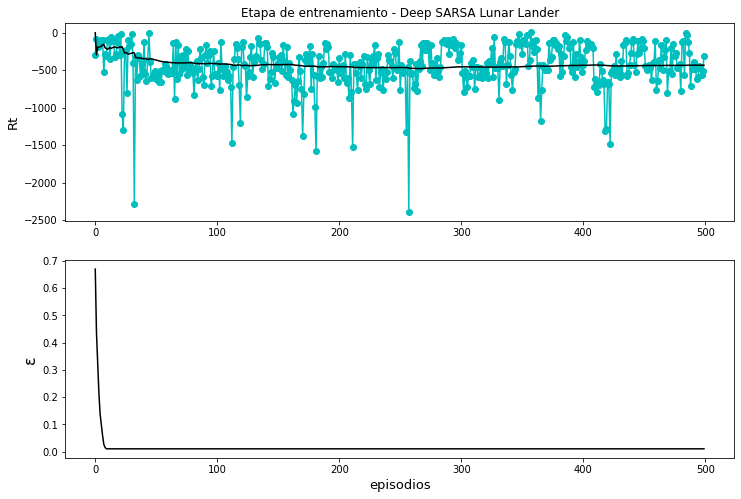

In [10]:
fig = plt.figure()
fig.set_size_inches(12, 8)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(steps, rewards, '-oc', steps, means, '-k')
ax2.plot(steps, epsilon, '-k')
ax1.set_title('Etapa de entrenamiento - Deep SARSA Lunar Lander')
ax1.set_ylabel('Rt', fontsize=13)
ax2.set_ylabel('ε', fontsize=16)
ax2.set_xlabel('episodios', fontsize=13)

plt.show()

### **Observar al agente en acción**

In [11]:
t, rewards = agent.run(episodes=200, load=True)

episode: 0/200, steps: 61, R: -466.708328146432
episode: 1/200, steps: 72, R: -482.35288204962774
episode: 2/200, steps: 49, R: -409.49477865835803
episode: 3/200, steps: 64, R: -596.4786484234247
episode: 4/200, steps: 58, R: -545.4632862747665
episode: 5/200, steps: 70, R: -653.4030316790731
episode: 6/200, steps: 82, R: -768.5138113789645
episode: 7/200, steps: 51, R: -394.9253721009866
episode: 8/200, steps: 56, R: -506.1227059067121
episode: 9/200, steps: 63, R: -512.2149174408581
episode: 10/200, steps: 68, R: -535.8914826834127
episode: 11/200, steps: 71, R: -482.12524382587753
episode: 12/200, steps: 68, R: -535.46062215753
episode: 13/200, steps: 68, R: -532.4762169445053
episode: 14/200, steps: 52, R: -386.77933616935223
episode: 15/200, steps: 71, R: -499.0455881714621
episode: 16/200, steps: 65, R: -513.732776040322
episode: 17/200, steps: 61, R: -535.9951552197022
episode: 18/200, steps: 81, R: -811.7492577331925
episode: 19/200, steps: 82, R: -500.859729936794
episode: 20

In [12]:
means = [0] + [sum(rewards[:num])/num for num in range(1, len(rewards))]
steps = [num for num, val in enumerate(rewards)]

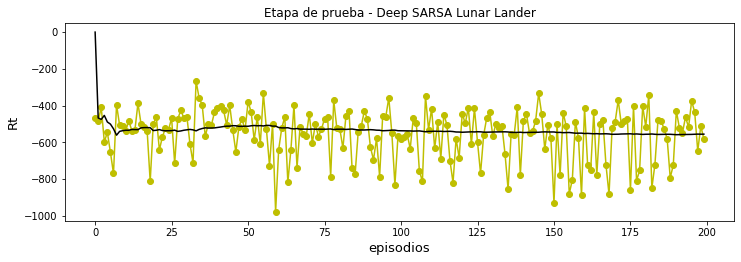

In [14]:
fig = plt.figure()
fig.set_size_inches(12, 8)
ax1 = fig.add_subplot(211)

ax1.plot(steps, rewards, '-oy', steps, means, '-k')
ax1.set_title('Etapa de prueba - Deep SARSA Lunar Lander')
ax1.set_ylabel('Rt', fontsize=13)
ax1.set_xlabel('episodios', fontsize=13)

plt.show()